In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import string, os 
import re
from tqdm import tqdm
import pickle
import json

In [3]:
# Loading the dataset
with open('dataset/data.json') as f:
  data = json.load(f)

len(data)

8628

In [4]:
# Extracting IDs from the Dataset
ids = []

j = 0

for key in data:
    j = j + 1
    for content in data[key]['content']:
        ids.append(j)

In [5]:
df2 = pd.DataFrame(ids, columns = ['conversation_id'])

In [6]:
df = pd.DataFrame.from_dict(data, orient = 'index')

In [7]:
df.reset_index(inplace = True)

In [8]:
df_1 = df['conversation_rating'].apply(pd.Series)
df = pd.concat([df.drop(columns = ['conversation_rating']), df_1], axis = 1)

In [9]:
df = df.explode('content')

# Resetting the index
df.reset_index(drop = True, inplace = True)

In [10]:
df_1 = df['content'].apply(pd.Series)
df = pd.concat([df.drop(columns = ['content']), df_1], axis = 1)

In [11]:
df.head()

,index,article_url,config,agent_1,agent_2,message,agent,sentiment,knowledge_source,turn_rating
0,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,https://www.washingtonpost.com/blogs/compost/w...,C,Excellent,Excellent,Are you a fan of Google or Microsoft?,agent_1,Curious to dive deeper,[FS1],Good
1,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,https://www.washingtonpost.com/blogs/compost/w...,C,Excellent,Excellent,Both are excellent technology they are helpful...,agent_2,Curious to dive deeper,[FS1],Excellent
2,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,https://www.washingtonpost.com/blogs/compost/w...,C,Excellent,Excellent,"I'm not a huge fan of Google, but I use it a ...",agent_1,Curious to dive deeper,[FS1],Good
3,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,https://www.washingtonpost.com/blogs/compost/w...,C,Excellent,Excellent,Google provides online related services and pr...,agent_2,Curious to dive deeper,[FS1],Excellent
4,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,https://www.washingtonpost.com/blogs/compost/w...,C,Excellent,Excellent,"Yeah, their services are good. I'm just not a ...",agent_1,Curious to dive deeper,[FS1],Good


In [12]:
# Seperating https, www, website name, the url after the website and converting all these into a tuple.
df['article_url'] = df['article_url'].str.findall(r"((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?")

In [13]:
df = df.explode('article_url')

In [14]:
df['genre'] = df['article_url'].apply(lambda col: col[6])

In [15]:
df['genre'] = df['genre'].apply(lambda x: x.split('/')[1].strip())

In [16]:
df = pd.concat([df2, df], axis=1)

In [17]:
df = df.drop(['index', 'article_url', 'config', 'agent_1', 'agent_2', 'agent', 'knowledge_source', 'turn_rating'], axis = 1)

In [18]:
df.head()

,conversation_id,message,sentiment,genre
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper,blogs
1,1,Both are excellent technology they are helpful...,Curious to dive deeper,blogs
2,1,"I'm not a huge fan of Google, but I use it a ...",Curious to dive deeper,blogs
3,1,Google provides online related services and pr...,Curious to dive deeper,blogs
4,1,"Yeah, their services are good. I'm just not a ...",Curious to dive deeper,blogs


In [19]:
# Attempting to connect to a TPU cluster.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


In [20]:
batch_size = 64 # Batch size for training.
epochs = 120 # Number of epochs for training.
latent_dim = 512 # Latent dimensionality of the encoding space.
num_samples = 50000 # Number of Samples.

In [21]:
# Preprocessing the messages | Removing punctuations and converting text into lower case.
def process(msg):
    msg = msg.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    msg = "".join(v for v in msg if v not in string.punctuation).lower()

    msg = " ".join(msg.split())
    return text


In [22]:
df['message'] = df['message'].apply(process)

In [23]:
df.head()

,conversation_id,message,sentiment,genre
0,1,are you a fan of google or microsoft,Curious to dive deeper,blogs
1,1,both are excellent technology they are helpful...,Curious to dive deeper,blogs
2,1,im not a huge fan of google but i use it a lot...,Curious to dive deeper,blogs
3,1,google provides online related services and pr...,Curious to dive deeper,blogs
4,1,yeah their services are good im just not a fan...,Curious to dive deeper,blogs


In [24]:
# Converting the data into vectors | Vectorization.
input_texts = []
target_texts = []
input_words_set = set()
target_words_set = set()

for conversation_index in tqdm(range(df.shape[0])):
    
    if conversation_index == 0:
        continue
        
    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]
    
    if input_text.conversation_id == target_text.conversation_id:
        
        input_text = input_text.message
        target_text = target_text.message
        
        if len(input_text.split()) > 2 and \
            len(target_text.split()) > 0 and \
            len(input_text.split()) < 30 and \
            len(target_text.split()) < 10 and \
            input_text and \
            target_text:
            
            target_text = "bos " + target_text + " eos"
                
            input_texts.append(input_text)
            target_texts.append(target_text)
            
            for word in input_text.split():
                if word not in input_words_set:
                    input_words_set.add(word)
            for word in target_text.split():
                if word not in target_words_set:
                    target_words_set.add(word)

100%|██████████| 188378/188378 [00:54<00:00, 3472.33it/s]


In [57]:
input_texts

['yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger',
 'yes he even won a hardcore cha cha championship in 1958',
 'true did you know jackson had a patent on a dancing device',
 'yes it helped him smooth out his dance moves',
 'i wonder if they met how that would go from there',
 'oh yeah i didnt know that either i also want to go to google plex to see the goats who mow their lawn by eating it',
 'hi do you like to dance',
 'dancing is a lot of fun did you know that bruce lee was a great dancer',
 'he was indeed his music is even in the library of congress',
 'wow that is amazing coming from such a talented singer and dancer i couldnt even dance like that even if i dreamed of it',
 'i heard that some professional ballet dancer can go through four pairs of shoes in a week',
 'ha ha it was so nice chatting with you as well have a nice day bye',
 'yes he was in the nutcracker as the mouse king',
 'i wonder if they had met w

In [58]:
target_texts

['bos by the way do you like fish eos',
 'bos yeah did you know tupac was a ballet dancer eos',
 'bos yes it helped him smooth out his dance moves eos',
 'bos nice do you like shakespeare eos',
 'bos yeah interesting point nice chat eos',
 'bos say what now they have that eos',
 'bos i love to dance a lot how about you eos',
 'bos i heard that winning cha cha championships and everything eos',
 'bos i didnt know this thanks for sharing eos',
 'bos me neither i could never be a professional dancer eos',
 'bos that is crazy that cant be cheap for them eos',
 'bos bye eos',
 'bos yeah do you like shakespeare eos',
 'bos yeah good point he also invented some womens names eos',
 'bos yes among those are olivia miranda and jessica eos',
 'bos do you know how google maps calculates traffic eos',
 'bos i am not sure how do they do this eos',
 'bos they track how fast android devices are moving eos',
 'bos no i have what does the results turn eos',
 'bos i do like comic books eos',
 'bos hahah 

In [25]:
input_words = sorted(list(input_words_set))
target_words = sorted(list(target_words_set))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt.split()) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

#saving
with open('input_token_index.pickle', 'wb') as handle:
    pickle.dump(input_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#saving
with open('target_token_index.pickle', 'wb') as handle:
    pickle.dump(target_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

Number of samples: 20189
Number of unique input tokens: 12272
Number of unique output tokens: 7484
Max sequence length for inputs: 29
Max sequence length for outputs: 11


In [26]:
embedding_size = 100

# Creating seq2seq lstm model.
with strategy.scope():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None,))
    
    encoder_embedding_output = keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
                                               
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embedding_output
                                                
    encoder_states = [state_h, state_c]

    decoder_inputs = keras.Input(shape=(None,))
    
    decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size)
    decoder_embedding_output = decoder_embedding(decoder_inputs)
    
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    1227200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    748400      ['input_2[0][0]']                
                                                                                              

In [27]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs = 120,
    validation_split = 0.2,
)

Epoch 1/120
253/253 [==============================] - 334s 1s/step - loss: 3.9635 - accuracy: 0.1121 - val_loss: 3.8617 - val_accuracy: 0.1171
Epoch 2/120
253/253 [==============================] - 307s 1s/step - loss: 3.7335 - accuracy: 0.1230 - val_loss: 3.7919 - val_accuracy: 0.1260
Epoch 3/120
253/253 [==============================] - 289s 1s/step - loss: 3.6268 - accuracy: 0.1331 - val_loss: 3.7033 - val_accuracy: 0.1360
Epoch 4/120
253/253 [==============================] - 264s 1s/step - loss: 3.5320 - accuracy: 0.1411 - val_loss: 3.6390 - val_accuracy: 0.1449
Epoch 5/120
253/253 [==============================] - 261s 1s/step - loss: 3.4382 - accuracy: 0.1535 - val_loss: 3.5674 - val_accuracy: 0.1589
Epoch 6/120
253/253 [==============================] - 266s 1s/step - loss: 3.3420 - accuracy: 0.1660 - val_loss: 3.4938 - val_accuracy: 0.1704
Epoch 7/120
253/253 [==============================] - 257s 1s/step - loss: 3.2456 - accuracy: 0.1759 - val_loss: 3.4178 - val_accuracy:

253/253 [==============================] - 258s 1s/step - loss: 1.3937 - accuracy: 0.3727 - val_loss: 6.3317 - val_accuracy: 0.2016
Epoch 58/120
253/253 [==============================] - 256s 1s/step - loss: 1.3720 - accuracy: 0.3763 - val_loss: 6.4346 - val_accuracy: 0.2018
Epoch 59/120
253/253 [==============================] - 253s 1s/step - loss: 1.3561 - accuracy: 0.3796 - val_loss: 6.5338 - val_accuracy: 0.2002
Epoch 60/120
253/253 [==============================] - 255s 1s/step - loss: 1.3368 - accuracy: 0.3819 - val_loss: 6.6554 - val_accuracy: 0.2030
Epoch 61/120
253/253 [==============================] - 258s 1s/step - loss: 1.3199 - accuracy: 0.3848 - val_loss: 6.7394 - val_accuracy: 0.1977
Epoch 62/120
253/253 [==============================] - 263s 1s/step - loss: 1.3031 - accuracy: 0.3870 - val_loss: 6.8447 - val_accuracy: 0.1980
Epoch 63/120
253/253 [==============================] - 255s 1s/step - loss: 1.2813 - accuracy: 0.3908 - val_loss: 6.9452 - val_accuracy: 0.197

253/253 [==============================] - 257s 1s/step - loss: 0.4842 - accuracy: 0.5572 - val_loss: 13.9763 - val_accuracy: 0.1644
Epoch 114/120
253/253 [==============================] - 258s 1s/step - loss: 0.4638 - accuracy: 0.5625 - val_loss: 14.1646 - val_accuracy: 0.1636
Epoch 115/120
253/253 [==============================] - 261s 1s/step - loss: 0.4548 - accuracy: 0.5647 - val_loss: 14.3176 - val_accuracy: 0.1635
Epoch 116/120
253/253 [==============================] - 257s 1s/step - loss: 0.4451 - accuracy: 0.5671 - val_loss: 14.3999 - val_accuracy: 0.1633
Epoch 117/120
253/253 [==============================] - 256s 1s/step - loss: 0.4723 - accuracy: 0.5614 - val_loss: 14.5486 - val_accuracy: 0.1643
Epoch 118/120
253/253 [==============================] - 257s 1s/step - loss: 0.4506 - accuracy: 0.5657 - val_loss: 14.6803 - val_accuracy: 0.1661
Epoch 119/120
253/253 [==============================] - 255s 1s/step - loss: 0.4221 - accuracy: 0.5733 - val_loss: 14.8933 - val_ac

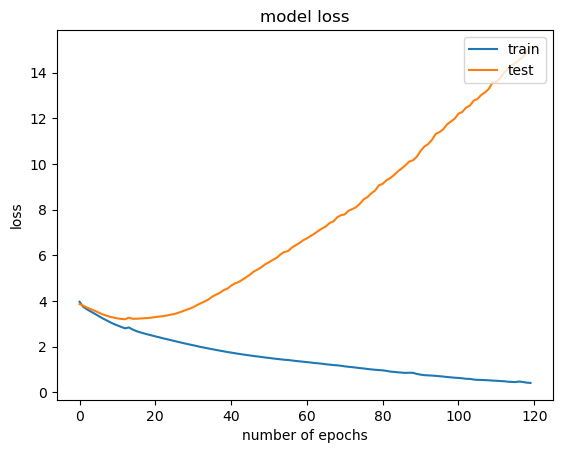

In [52]:
# Plot for Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

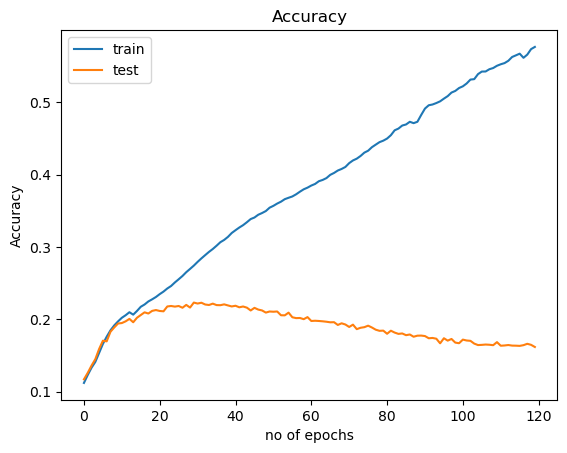

In [56]:
# Plot for Accuracy History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

In [29]:
# Saving the model
model.save("s2s.hdf5")

In [30]:
# Defining the encoder model 
encoder_model = keras.Model(encoder_inputs, encoder_states)
encoder_model.summary()

decoder_state_input_h = keras.Input(shape=(None,))
decoder_state_input_c = keras.Input(shape=(None,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_output = decoder_embedding(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1227200   
                                                                 
 lstm (LSTM)                 [(None, 512),             1255424   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 2,482,624
Trainable params: 2,482,624
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Saving Encoder and Decoder Model
encoder_model.save("encoder_model.hdf5")
decoder_model.save("decoder_model.hdf5")

In [32]:
# Creating a function which takes a sentence as input and returns it's output using encoder & decoder.

def respond(text):
    input_seq = np.zeros(
        (1, max_encoder_seq_length), dtype="float32"
    )
    
    for t, word in enumerate(text.split()):
        input_seq[0, t] = input_token_index[word]
        
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_token_index['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        if (sampled_char == 'eos' or
           len(decoded_sentence) > 50):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_char
            
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [42]:
respond("hello how are you")

1/1 [==============================] - 0s 22ms/step


' im doing great how bout yourself'

In [44]:
respond("good morning how are you doing")

1/1 [==============================] - 0s 22ms/step


' good do you like rap music'

In [46]:
respond("do you like rap music")

1/1 [==============================] - 0s 32ms/step


' i love it do you like the simpsons'

In [48]:
respond("do you like simpsons")

1/1 [==============================] - 0s 27ms/step


' i do like hockey how about you'

In [38]:
respond("good bye")

1/1 [==============================] - 0s 14ms/step


' have a great weekend'

In [49]:
respond("have a great weekend")

1/1 [==============================] - 0s 14ms/step


' you too'

In [36]:
# Taking 20 sentences from the training set and decoding it's output. 
for seq_index in range(20):
    decoded_sentence = respond(input_texts[seq_index])
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 18ms/step
-
Input sentence: yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger
Decoded sentence:  by the way do you follow youtube
1/1 [==============================] - 0s 26ms/step
-
Input sentence: yes he even won a hardcore cha cha championship in 1958
Decoded sentence:  yeah did you know tchaikovsky was obsessed with shakespeare
1/1 [==============================] - 0s 47ms/step
-
Input sentence: true did you know jackson had a patent on a dancing device
Decoded sentence:  yes it is the seahorse for they like fish
1/1 [==============================] - 0s 19ms/step
-
Input sentence: yes it helped him smooth out his dance moves
Decoded sentence:  nice do you have a dog
1/1 [==============================] - 0s 20ms/step
-
Input sentence: i wonder if they met how that would go from there
Decoded sentence:  yeah interesting point nice chat
1/1 [==============================] -

1/1 [==============================] - 0s 29ms/step
-
Input sentence: i wonder if they had met what he would have written about her
Decoded sentence:  yeah good point they held to check back in traditional
1/1 [==============================] - 0s 25ms/step
-
Input sentence: yeah good point he also invented some womens names
Decoded sentence:  yes among those are olivia miranda and jessica
1/1 [==============================] - 0s 21ms/step
-
Input sentence: and before on google moon they used to use cheese for close ups
Decoded sentence:  do you know how google maps calculates traffic
1/1 [==============================] - 0s 16ms/step
-
Input sentence: do you know how google maps calculates traffic
Decoded sentence:  i am not sure how do they dispense
1/1 [==============================] - 0s 66ms/step
-
Input sentence: i am not sure how do they do this
Decoded sentence:  they track how fast android devices are moving
1/1 [==============================] - 0s 39ms/step
-
Input senten